# K-Means Iris dataset

In [187]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


In [188]:
RANDOM_SEED = 9
DATASPLIT = 0.3
DATASET_ID= 109

In [189]:
logger = logging.getLogger(str(DATASET_ID))
logging.basicConfig(level=logging.DEBUG)

In [190]:
dataset = fetch_ucirepo(id=DATASET_ID)

df = pd.DataFrame(dataset.data.features)
df['class'] = dataset.data.targets

df = df.replace("?", pd.NA).dropna()

scaler = StandardScaler()

uneconded_labels = df['class']

data = df.drop(columns=['class'])

data = scaler.fit_transform(data)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

label_encoder = LabelEncoder()

df['class_encoded'] = label_encoder.fit_transform(uneconded_labels)

labels = df['class_encoded']


data_train, data_test, label_train, label_test = train_test_split(data_pca, labels, test_size=DATASPLIT, random_state=RANDOM_SEED)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=DATASPLIT, random_state=RANDOM_SEED)

logger.info(f"Train dataset length: {len(data_train)}, Validation dataset length: {len(data_val)}, Test dataset length: {len(data_test)}")





INFO:109:Train dataset length: 86, Validation dataset length: 38, Test dataset length: 54


In [191]:
parameters = {
    'n_clusters': range(2, 10, 1),
    'max_iter': range(100, 500, 100),
}


clf = GridSearchCV(KMeans(random_state=RANDOM_SEED), parameters, scoring='accuracy', verbose=0)
clf.fit(data_val, label_val)

model = clf.best_estimator_
logger.info("Best cross-validation score: %f", clf.best_score_)
logger.info("With parameters: %s", clf.best_params_)

logger.info("Training model with best parameters")
model.fit(data_train, label_train)

predictions = model.predict(data_test)
accuracy = accuracy_score(label_test, predictions)
logger.info("Accuracy: %f", accuracy)



ari = adjusted_rand_score(label_test, predictions)
logger.info(f"ARI score: {ari}")


INFO:109:Best cross-validation score: 0.392857
INFO:109:With parameters: {'max_iter': 100, 'n_clusters': 2}
INFO:109:Training model with best parameters
INFO:109:Accuracy: 0.092593
INFO:109:ARI score: 0.5588973534721916


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x747e92cb4500>


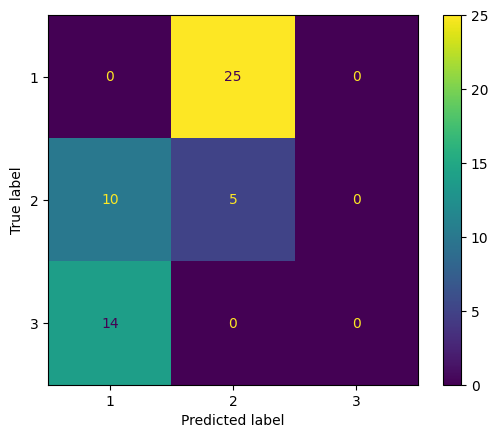

In [192]:
cm = confusion_matrix(label_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


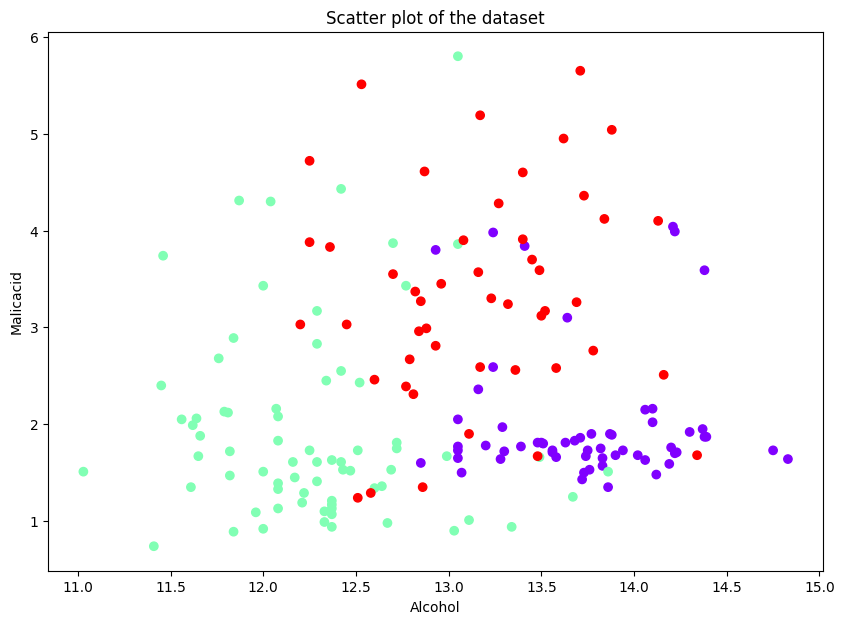

In [193]:

plt.figure(figsize=(10, 7))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df['class_encoded'], cmap='rainbow')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Scatter plot of the dataset")
plt.show()